# Face generation with DCGAN

В этом ноутбуке мы научим нейронную сеть генерировать лица людей.

In [1]:
!git init .
!git remote add -f origin "https://github.com/Sankek/DCGAN_FaceGeneration"
!git pull origin master

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 8), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (23/23), done.
From https://github.com/Sankek/DCGAN_FaceGeneration
 * [new branch]      master     -> origin/master
From https://github.com/Sankek/DCGAN_FaceGeneration
 * branch            master     -> FETCH_HEAD


In [2]:
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataset import FacesDataset
from utils import tensor2image, load_models, save_models, random_noise_vectors
from models import DiscriminatorNet, GeneratorNet, weights_init
from train import train

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {DEVICE}")

Current device: cuda


## Загрузка датасета

Обучать модели будем на части датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), изображения в котором уменьшены до размера 128x128.

In [4]:
batch_size = 16

dataset = FacesDataset(path='faces_dataset_resized', download=True)
dataset_mean = dataset.mean  # Нормализация картинок в датасете
dataset_std = dataset.std
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)

Downloading...
From: https://drive.google.com/uc?id=18X8g6DH5rZ1P9Ty0Yxyge7Pb7aWB21Ji
To: /content/faces_dataset_resized.zip
100%|██████████| 103M/103M [00:02<00:00, 42.9MB/s] 


Loading images...
Images are loaded!


Проверим, что загрузка данных и преобразование из тензоров в обычные изображения работает нормально:

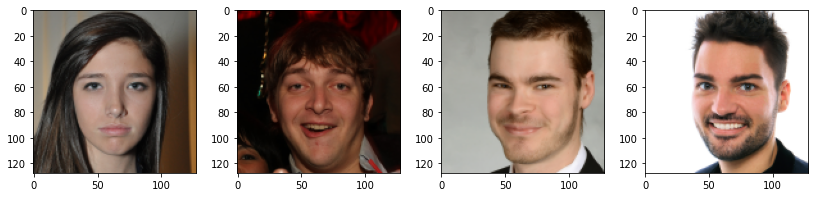

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
example_faces = next(iter(dataloader))
for i in range(4):
    axs[i].imshow(tensor2image(example_faces[i], dataset_mean, dataset_std))
plt.show()

## Инициализация модели

In [6]:
latent_size = 100  # Размер вектора шума, из которого генерируется изображение
generator = GeneratorNet(latent_size)  # на выходе должны быть числа в диапазоне [-1, 1] для корректной работы
discriminator = DiscriminatorNet()

generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)

## Обучение

In [7]:
lr = 1e-4

models = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = nn.BCEWithLogitsLoss()

optimizers = {
    "discriminator": torch.optim.Adam(models['discriminator'].parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(models['generator'].parameters(), lr=3*lr, betas=(0.5, 0.999))
}

# Apply the weights_init function to randomly initialize all weights
# with mean=0, stdev=0.02.
models['discriminator'].apply(weights_init)
models['generator'].apply(weights_init)

models['discriminator'].train()
models['generator'].train()

D_losses_real, D_losses_fake, G_losses = [], [], []

In [ ]:
losses_pack = train(
    models, latent_size, criterion, optimizers, dataloader, 
    dataset_mean, dataset_std, epochs=1, device=DEVICE
)

D_losses_real += losses_pack[0]
D_losses_fake += losses_pack[1]
G_losses += losses_pack[2]

In [ ]:
# Сохранение модели

losses = [D_losses_real, D_losses_fake, G_losses]
save_name = 'trained'
save_models(
    models['discriminator'], models['generator'], 
    optimizers['discriminator'], optimizers['generator'], 
    losses, save_name
)

In [ ]:
# Загрузка модели

load_name = 'trained'
D_losses_real, D_losses_fake, G_losses = load_models(
    models['discriminator'], models['generator'], 
    optimizers['discriminator'], optimizers['generator'], 
    load_name, device=DEVICE
)

## Просмотр результатов

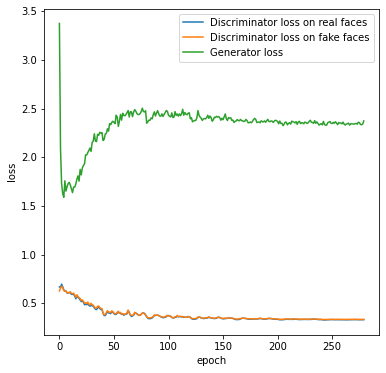

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(D_losses_real, label="Discriminator loss on real faces")
ax.plot(D_losses_fake, label="Discriminator loss on fake faces")
ax.plot(G_losses, label="Generator loss")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.show()

In [10]:
images_num = 16
noise_vectors = random_noise_vectors(images_num, latent_size, device=DEVICE)
generated_images = [tensor2image(genim, dataset_mean, dataset_std) for genim in generator(noise_vectors)]

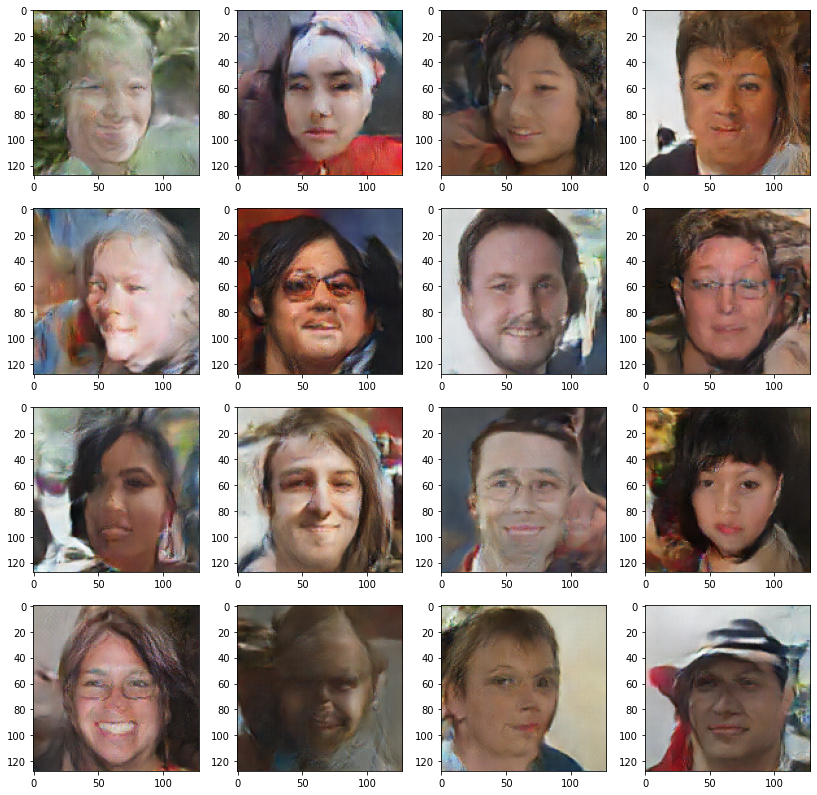

In [11]:
rows_num = 4
cols_num = 4
fig, axs = plt.subplots(rows_num, cols_num, figsize=(14, 14), squeeze=False)
for i in range(images_num):
    axs[i//rows_num, i%cols_num].imshow(generated_images[i])
plt.show()

## Визуализация распределений

Сгенерируем столько картинок, сколько есть в нашем датасете. Понизим размерность с помощью TSNE и сравним получившиеся распределения.

In [12]:
# Генерация фейковых изображений

generated_images = []
generated_num = 0
with tqdm(total=len(dataset)) as pbar:
    while generated_num < len(dataset):
        gen_batch_size = min(batch_size, len(dataset)-generated_num)

        with torch.no_grad():
            noise_vectors = random_noise_vectors(gen_batch_size, latent_size, device=DEVICE)
            generated = models['generator'](noise_vectors)

        generated_images += generated.cpu()
        pbar.update(gen_batch_size)
        generated_num += gen_batch_size
generated_images = torch.stack(generated_images)

  0%|          | 0/3143 [00:00<?, ?it/s]

In [13]:
real_images = torch.stack([im for im in dataset])

In [14]:
all_images = torch.concat((generated_images, real_images))
all_images = all_images.view(all_images.shape[0], -1)
all_images_y = torch.concat((torch.zeros(generated_images.shape[0]), torch.ones(real_images.shape[0])))

In [15]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto').fit_transform(all_images)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


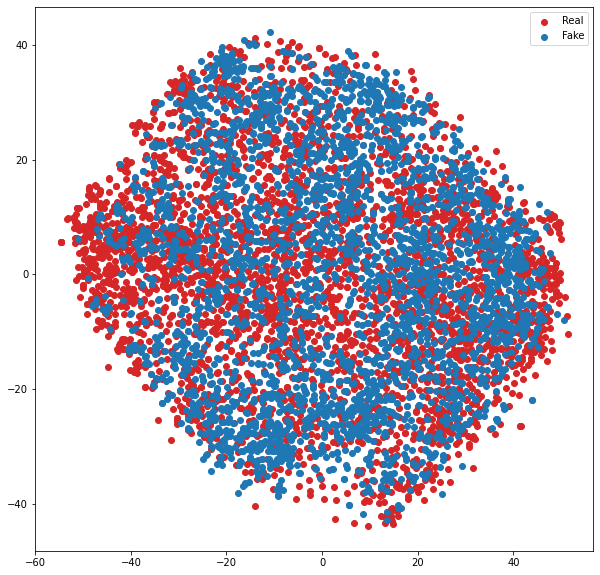

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_embedded[:, 0][all_images_y == 1], X_embedded[:, 1][all_images_y == 1], color='tab:red', label='Real')
ax.scatter(X_embedded[:, 0][all_images_y == 0], X_embedded[:, 1][all_images_y == 0], color='tab:blue', label='Fake')
plt.legend(loc='best')
plt.show()